<a href="https://colab.research.google.com/github/wjshku/ML-Pytorch/blob/main/Lesson3/pytorch_lesson3_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercises

Try out the following exercises to apply the concepts and techniques you have learned so far:

* Coding exercises on end-to-end model training: https://jovian.ai/aakashns/03-cifar10-feedforward
* Starter notebook for deep learning models:  https://jovian.ai/aakashns/fashion-feedforward-minimal

Training great machine learning models reliably takes practice and experience. Try experimenting with different datasets, models and hyperparameters, it's the best way to acquire this skill.

#### Flowchart of this project:
**1. Download the dataset**
2. Prepare the dataset for training and build dataset/dataloader
3. Write functions to connect with GPU
4. Construct Model class
5. Write fit function and run 20 epochs
6. Make predictions


In [90]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [91]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [92]:
num_classes = 10
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

torch.Size([3, 32, 32])
6
frog
32
tensor([[0.2314, 0.1686, 0.1961,  ..., 0.8471, 0.5922, 0.4824],
        [0.2431, 0.1804, 0.1882,  ..., 0.7216, 0.4627, 0.3608],
        [0.2471, 0.1765, 0.1686,  ..., 0.5490, 0.3294, 0.2824]])


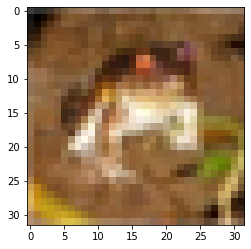

In [93]:
image, labels = dataset[0]
print(image.shape)
print(labels)
print(classes[labels])
print(image.size(2))
print(image.view(image.size(0), -1))
plt.imshow(image.permute(1,2,0))

In [94]:
data_size = len(dataset)
proportion = 0.9
train_size = int(data_size * proportion)
val_size = data_size - train_size

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([100, 3, 32, 32])


TypeError: ignored

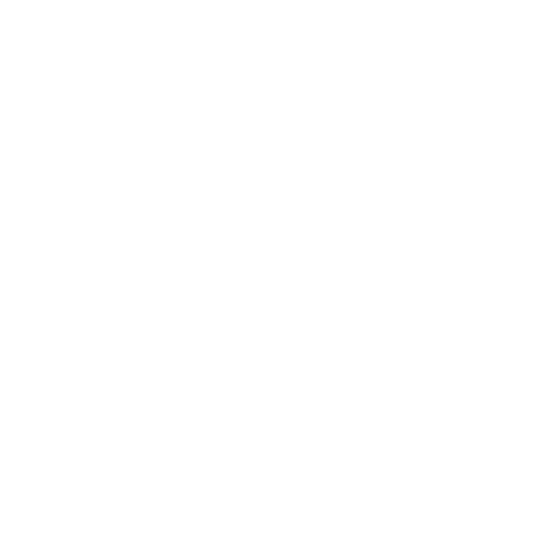

In [95]:
for images,_ in train_dl:
  print(images.shape)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
  break

#### Flowchart of this project:
1. Download the dataset
**2.Prepare the dataset for training and build dataset/dataloader**
3. Write functions to connect with GPU
4. Construct Model class
5. Write fit function and run 20 epochs
6. Make predictions

In [96]:
train_ds, val_ds = random_split(dataset,[train_size,val_size])
batch_size = 128

In [97]:
train_dl = DataLoader(train_ds, batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Flowchart of this project:
1. Download the dataset
2.Prepare the dataset for training and build dataset/dataloader
**3. Write functions to connect with GPU**
4. Construct Model class
5. Write fit function and run 20 epochs
6. Make predictions

In [ ]:
torch.cuda.is_available()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

In [ ]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device)

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

In [98]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
def to_device_dataloader(dataloader,device):
  for batch in dataloader:
    to_device(batch,device)

In [ ]:
to_device_dataloader(train_dl,device)
to_device_dataloader(val_dl,device)
len(train_dl)

#### Flowchart of this project:
1. Download the dataset
2.Prepare the dataset for training and build dataset/dataloader
3. Write functions to connect with GPU
**4. Construct Model class**
5. Write fit function and run 20 epochs
6. Make predictions

In [ ]:
class CIFARModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [100]:
for image, labes in train_dl:
  print(image.view(image.size(0),-1).shape)
  model(image)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3072])


In [101]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [102]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [148]:
input_size = 3*32*32
hidden_size = 3*32
out_size = 10
# Model (on GPU)
model = CIFARModel(input_size,hidden_size,out_size)
to_device(model, device)

CIFARModel(
  (linear1): Linear(in_features=3072, out_features=96, bias=True)
  (linear2): Linear(in_features=96, out_features=10, bias=True)
)

#### Flowchart of this project:
1. Download the dataset
2.Prepare the dataset for training and build dataset/dataloader
3. Write functions to connect with GPU
4. Construct Model class
**5. Write fit function and run 20 epochs**
6. Make predictions

In [149]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09550781548023224, 'val_loss': 2.3171684741973877}]

In [157]:
history += fit(5, 0.1, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.5396, val_acc: 0.4693
Epoch [1], val_loss: 1.5712, val_acc: 0.4533
Epoch [2], val_loss: 1.4886, val_acc: 0.4848
Epoch [3], val_loss: 1.5714, val_acc: 0.4408
Epoch [4], val_loss: 1.5212, val_acc: 0.4660


In [122]:
history += fit(5, 0.001, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.6149, val_acc: 0.4340
Epoch [1], val_loss: 1.6146, val_acc: 0.4309
Epoch [2], val_loss: 1.6141, val_acc: 0.4338
Epoch [3], val_loss: 1.6144, val_acc: 0.4354
Epoch [4], val_loss: 1.6139, val_acc: 0.4316


In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

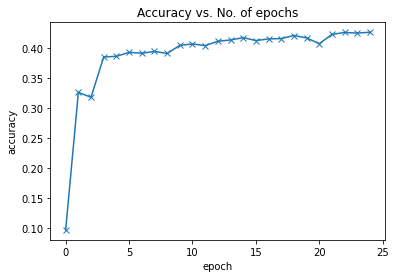

In [147]:
accuracies = [x['val_acc'] for x in record[0]]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [142]:
record = []

In [145]:
#Record:
# (3072,32,10) * 10 --> 0.4260
record += [history]